In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from statsmodels.stats.outliers_influence import summary_table
from scipy import stats

# Data loading
Я обрав компанію Goldman Sachs.

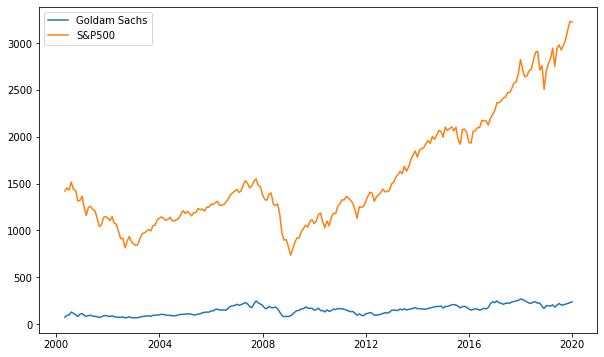

In [2]:
dateparse = lambda dates: pd.datetime.strptime(dates, '%Y-%m-%d')
data_gs = pd.read_csv('GS.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)
data_sp500 = pd.read_csv('^GSPC.csv', parse_dates=['Date'], index_col='Date',date_parser=dateparse)

plt.figure(figsize=(10, 6))
plt.plot(data_gs['Close'], label='Goldam Sachs')
plt.plot(data_sp500['Close'], label='S&P500')
plt.legend();

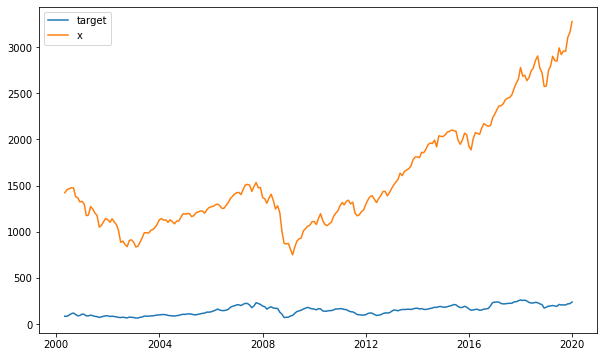

In [3]:
target = (data_gs['High'] + data_gs['Low']) / 2.
data_sp500['x'] = (data_sp500['High'] + data_sp500['Low'])/2.
data_sp500['x_squared'] = data_sp500['x'] ** 2

plt.figure(figsize=(10, 6))
plt.plot(target, label='target')
plt.plot(data_sp500['x'], label='x')
plt.legend();

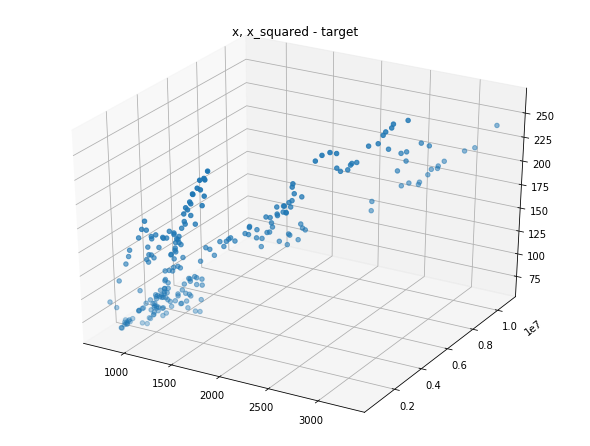

In [4]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
plt.title('x, x_squared - target')
ax.scatter(data_sp500['x'], data_sp500['x_squared'], target)
plt.show()

### Model parameters

In [5]:
def model_parameters(x, y):
    import statsmodels.api as sm
    X = sm.add_constant(x)
    model = sm.OLS(y, X)
    lin = model.fit()
    return lin

def predict(b_0, b_1, b_2, x):
    y_hat = b_0 + b_1 * x[:, 0] + b_2 * x[:, 1]
    return y_hat

In [6]:
model = model_parameters(data_sp500[['x', 'x_squared']].values, target)
b_0, b_1, b_2 = model.params
y_hat = predict(b_0, b_1, b_2, data_sp500[['x', 'x_squared']].values)
yprd_ci_lower, yprd_ci_upper = summary_table(model, alpha = 0.05)[1][:, 4:6].T

In [7]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.641
Model:                            OLS   Adj. R-squared:                  0.638
Method:                 Least Squares   F-statistic:                     209.3
Date:                Thu, 16 Apr 2020   Prob (F-statistic):           7.54e-53
Time:                        19:21:24   Log-Likelihood:                -1147.4
No. Observations:                 237   AIC:                             2301.
Df Residuals:                     234   BIC:                             2311.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        -34.8323     18.617     -1.871      0.063     -71.510       1.846
x1             0.1633      0.022      7.445      0.000       0.120       0.207
x2         -2.568e-05   5.79e-06     -4.437      0.000   -3.71e-05   -1.43e-05
==============================================================================
Omnibus:                       17.218   Durbin-Watson:                   0.075
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               16.873
Skew:                           0.600   Prob(JB):                     0.000217
Kurtosis:                       2.480   Cond. No.                     3.38e+07
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.38e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [8]:
print('Multi-Factor Model')
print('Parameters: \nb_0: {} b_1: {} b_2: {}'.format(np.round(b_0, 3), np.round(b_1, 3), np.round(b_2, 3)))
print('===============================================')
print(f'R_squared: {np.round(model.rsquared, 3)}   r:{np.round(np.sqrt(model.rsquared), 3)}  F-statistic: {np.round(model.fvalue, 3)}')

Multi-Factor Model
Parameters: 
b_0: -34.832 b_1: 0.163 b_2: -0.0
R_squared: 0.641   r:0.801  F-statistic: 209.345


Given our F-statistic of 209.345 with a corresponding p_value of 0.000 we can conclude that out model is significant and all coef $\ne$ 0

### Plotting

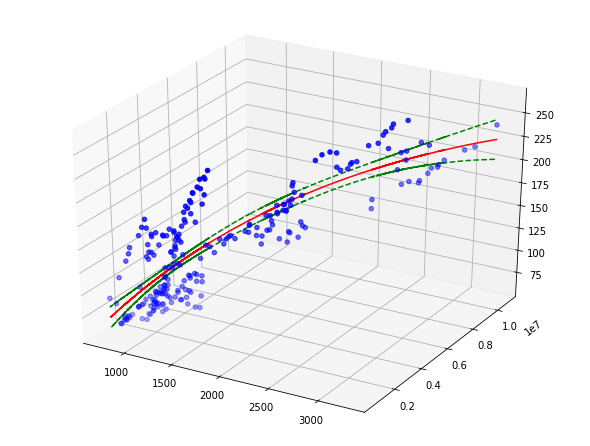

In [9]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(data_sp500['x'], data_sp500['x_squared'], target, linestyle = "None", marker = "o", label = "actual",  color = "blue")
ax.plot(data_sp500['x'], data_sp500['x_squared'], y_hat, color='red')
ax.plot(data_sp500['x'], data_sp500['x_squared'], yprd_ci_lower, color='green', linestyle='--')
ax.plot(data_sp500['x'], data_sp500['x_squared'], yprd_ci_upper, color='green', linestyle='--')
plt.show()

# Forecast

In [10]:
x_mat = np.append([1], data_sp500[['x', 'x_squared']].values[-1] * 1.2)

dt = model.get_prediction(x_mat).summary_frame(alpha = 0.05)
y_prd = dt['mean']
y_prd_ci_lower = dt['obs_ci_lower']
y_prd_ci_upper = dt['obs_ci_upper']

print(f'x = {x_mat[1]} y_hat = {y_prd[0]}')
print(f'y confidence intervals: ({y_prd_ci_lower[0]}, {y_prd_ci_upper[0]})')

x = 3931.4459477999994 y_hat = 276.37816491039695
y confidence intervals: (212.00062192124085, 340.75570789955304)


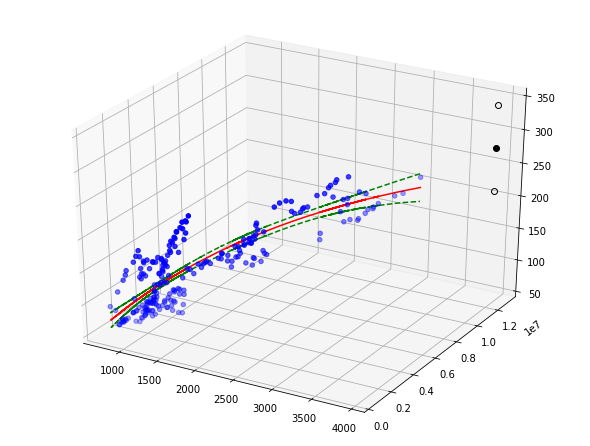

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig)
ax.scatter(data_sp500['x'], data_sp500['x_squared'], target, linestyle = "None", marker = "o", label = "actual",  color = "blue")
ax.plot(data_sp500['x'], data_sp500['x_squared'], y_hat, color='red')
ax.plot(data_sp500['x'], data_sp500['x_squared'], yprd_ci_lower, color='green', linestyle='--')
ax.plot(data_sp500['x'], data_sp500['x_squared'], yprd_ci_upper, color='green', linestyle='--')
ax.plot([x_mat[1]], [x_mat[2]], y_prd, color='black', marker="o", label='forecast')
ax.plot([x_mat[1]], [x_mat[2]], y_prd_ci_lower, color='black', marker="o", markerfacecolor = "None", label='forecast')
ax.plot([x_mat[1]], [x_mat[2]], y_prd_ci_upper, color='black', marker="o", markerfacecolor = "None", label='forecast')
plt.show()